# Framework-Agnostic Interpretability

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/tutorials/framework-agnostic-interpretability.ipynb)


## Setup


In [1]:
import importlib.util

DEV = True

if importlib.util.find_spec("google.colab") is not None:
    MODE = "colab-dev" if DEV else "colab"
else:
    MODE = "local"

In [2]:
if MODE == "colab":
    %pip install -q lczerolens
elif MODE == "colab-dev":
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b main
    %pip install -q ./lczerolens

## Load a Model and Board


In [3]:
from lczerolens import LczeroModel

model = LczeroModel.from_hf("lczerolens/256x19-4508")
model

LczeroModel(
    module=GraphModule(
      (inputconv): Conv2d(112, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (inputconv/relu): ReLU()
      (block0/conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (block0/conv1/relu): ReLU()
      (block0/conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (block0/conv2/se/pooled): OnnxGlobalAveragePoolWithKnownInputShape()
      (initializers): Module()
      (block0/conv2/se/squeeze): OnnxSqueezeDynamicAxes()
      (block0/conv2/se/matmul1): OnnxMatMul()
      (block0/conv2/se/add1): OnnxBinaryMathOperation()
      (block0/conv2/se/relu): ReLU()
      (block0/conv2/se/matmul2): OnnxMatMul()
      (block0/conv2/se/add2): OnnxBinaryMathOperation()
      (block0/conv2/se/reshape): OnnxReshape()
      (block0/conv2/se/split): OnnxSplit13()
      (block0/conv2/se/sigmoid): Sigmoid()
      (block0/conv2/se/mul): OnnxBinaryMathOperation()
      (block0/conv2/se/add3): OnnxBi

In [4]:
from tensordict import TensorDict
from lczerolens import LczeroBoard

board = LczeroBoard(fen="1rb1rbk1/2qn1p1p/p2p2p1/1ppPp2n/PP2P3/2P1BN1P/R1BN1PP1/3QR1K1 w - - 0 22")
td = TensorDict({"board": board.to_input_tensor().unsqueeze(0)}, batch_size=[1])
td

TensorDict(
    fields={
        board: Tensor(shape=torch.Size([1, 112, 8, 8]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False)

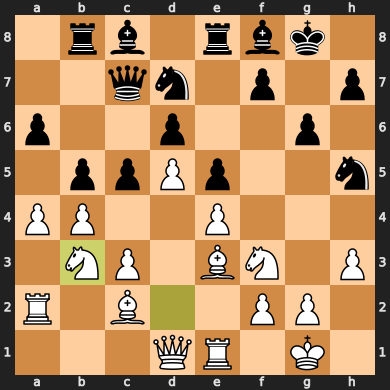

In [5]:
policy = model(board)["policy"]

legal_indices = board.get_legal_indices()
legal_policy = policy[0].gather(0, legal_indices)
best_move_index = legal_indices[legal_policy.argmax()]
move = board.decode_move(best_move_index)

board.push(move)
display(board)

## Causal Mediation Analysis with `nnsight`

In [6]:
# TODO: Complete this section

## Integral-Gradient with `captum`

In [7]:
import torch


def mlh_forward(board: LczeroBoard) -> torch.Tensor:
    return model(board)["mlh"]


baseline = torch.zeros_like(td["board"])
print("wdl (board):", mlh_forward(board))
print("wdl (baseline):", mlh_forward(baseline))

wdl (board): tensor([[105.5060]], grad_fn=<CloneBackward0>)
wdl (baseline): tensor([[0.]], grad_fn=<CloneBackward0>)


In [8]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(mlh_forward)
attributions, approximation_error = ig.attribute(td["board"], baselines=baseline, return_convergence_delta=True)

approximation_error

tensor([-3.6674])

In [9]:
import IPython.display

heatmap = attributions.mean(dim=1)

svg_board, svg_colorbar = board.render_heatmap(heatmap[0].view(64).detach(), normalise="abs")
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))

## LRP with `zennit`

In [10]:
import torch
from torch.autograd import Function


def stabilize(tensor, epsilon=1e-6):
    return tensor + epsilon * ((-1) ** (tensor < 0))


class AddEpsilonFunction(Function):
    @staticmethod
    def forward(ctx, input_a, input_b, epsilon=1e-6):
        output = input_a + input_b
        ctx.save_for_backward(input_a, input_b, output, torch.tensor(epsilon))
        return output

    @staticmethod
    def backward(ctx, *grad_output):
        input_a, input_b, output, epsilon = ctx.saved_tensors
        out_relevance = grad_output[0] / stabilize(output, epsilon)
        return out_relevance * input_a, out_relevance * input_b, None


class AddEpsilon(torch.nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x, y):
        return AddEpsilonFunction.apply(x, y, self.epsilon)


class MatMulEpsilonFunction(Function):
    @staticmethod
    def forward(ctx, input, param, epsilon=1e-6):
        output = torch.matmul(input, param)
        ctx.save_for_backward(input, param, output, torch.tensor(epsilon))

        return output

    @staticmethod
    def backward(ctx, *grad_outputs):
        input, param, output, epsilon = ctx.saved_tensors
        out_relevance = grad_outputs[0]

        out_relevance = out_relevance / stabilize(output, epsilon)
        relevance = (out_relevance @ param.T) * input
        return relevance, None, None


class MatMulEpsilon(torch.nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x, y):
        return MatMulEpsilonFunction.apply(x, y, self.epsilon)


class MulUniformFunction(Function):
    @staticmethod
    def forward(ctx, input_a, input_b):
        return input_a * input_b

    @staticmethod
    def backward(ctx, *grad_outputs):
        relevance = grad_outputs[0] * 0.5

        return relevance, relevance


class MulUniform(torch.nn.Module):
    def forward(self, x, y):
        return MulUniformFunction.apply(x, y)

In [11]:
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import LayerMapComposite
from zennit.rules import Epsilon, Pass, ZPlus
from zennit.types import Activation
import onnx2torch

canonizers = [SequentialMergeBatchNorm()]
layer_map = [
    (Activation, Pass()),
    (torch.nn.Conv2d, ZPlus()),
    (torch.nn.Linear, Epsilon(epsilon=1e-6)),
    (torch.nn.AdaptiveAvgPool2d, Epsilon(epsilon=1e-6)),
]
composite = LayerMapComposite(layer_map=layer_map, canonizers=canonizers)

new_module_mapping = {}
old_module_mapping = {}
for name, module in model.named_modules():
    if name == "":
        continue
    if isinstance(module, torch.nn.Softmax):
        new_module_mapping[name] = torch.nn.Identity()
        old_module_mapping[name] = module
    if isinstance(module, onnx2torch.node_converters.OnnxBinaryMathOperation):
        if module.math_op_function is torch.add:
            new_module_mapping[name] = AddEpsilon()
            old_module_mapping[name] = module
        elif module.math_op_function is torch.mul:
            new_module_mapping[name] = MulUniform()
            old_module_mapping[name] = module
    elif isinstance(module, onnx2torch.node_converters.OnnxMatMul):
        new_module_mapping[name] = MatMulEpsilon()
        old_module_mapping[name] = module
    elif isinstance(module, onnx2torch.node_converters.OnnxFunction):
        if module.function is torch.tanh:
            new_module_mapping[name] = torch.nn.Tanh()
            old_module_mapping[name] = module
    elif isinstance(
        module,
        onnx2torch.node_converters.OnnxGlobalAveragePoolWithKnownInputShape,  # noqa
    ):
        new_module_mapping[name] = torch.nn.AdaptiveAvgPool2d(1)
        old_module_mapping[name] = module
for name, module in new_module_mapping.items():
    setattr(model, name, module)

In [12]:
with composite.context(model) as modified_model:
    td["board"].requires_grad_(True)
    output = modified_model(td["board"])["policy"]

    (relevance,) = torch.autograd.grad(output[:, best_move_index], td["board"])

In [13]:
import IPython.display

heatmap = relevance.mean(dim=1)

svg_board, svg_colorbar = board.render_heatmap(heatmap[0].view(64).detach(), normalise="abs")
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))

In [14]:
for name, module in old_module_mapping.items():
    setattr(model, name, module)

## Activation Maximisation with `tdhook`

In [15]:
# TODO: Complete this section